In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import tensorflow as tf
import PIL
import os, glob, random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

VERSION = 4
SAVEFILE = 'mtg_back_front_classifier_v%03d' % VERSION

In [2]:
# see https://medium.com/@JeansPantRushi/fix-for-tensorflow-v2-failed-to-get-convolution-algorithm-b367a088b56e
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print(tf.config.experimental.list_physical_devices('GPU'))
print(tf.version.VERSION)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.1.0


# Build Model (Tensorflow 2.)

In [3]:
#IMG_HEIGHT, IMG_WIDTH = (48, 64)
IMG_HEIGHT, IMG_WIDTH = (96, 128)

if os.path.exists(SAVEFILE):
    model = tf.keras.models.load_model(SAVEFILE)
else:
    model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        #Dense(1, activation='sigmoid')
        Dense(9)
    ])

model.compile(optimizer='adam',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 128, 16)       448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 64, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 48, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 16, 64)        0

# Build training vectors

In [4]:
TRAIN_DIR = 'train'
VALIDATION_DIR = 'validation'

train_image_generator = ImageDataGenerator(rescale=1./255,
                                           rotation_range=5,
                                           width_shift_range=.1,
                                           height_shift_range=.1,
                                           brightness_range=(.5,1.5),
                                           shear_range=0.1,
                                           channel_shift_range=0.1,
                                           zoom_range=0.1,
                                           ) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
train_data_gen = train_image_generator.flow_from_directory(batch_size=100,
                                                           directory=TRAIN_DIR,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=100,
                                                              directory=VALIDATION_DIR,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 1021 images belonging to 9 classes.
Found 179 images belonging to 9 classes.


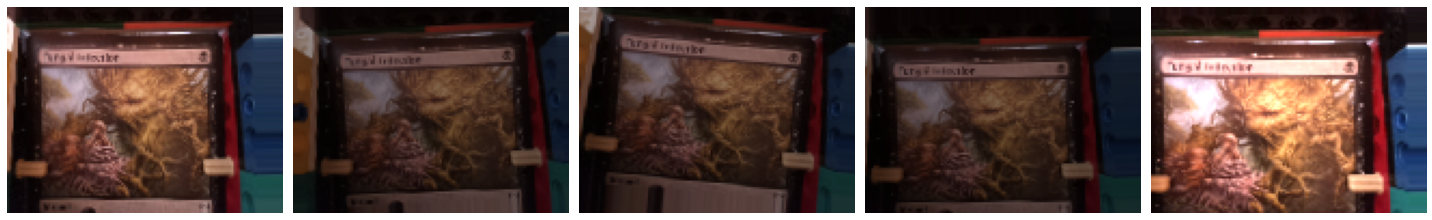

In [5]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plot_imgs(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plot_imgs(augmented_images)

# Train Model

In [5]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.samples/train_data_gen.batch_size,
    epochs=300,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.samples/val_data_gen.batch_size,
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 10.21 steps, validate for 1.79 steps
Epoch 1/300
11/10 [================================] - 7s 619ms/step - loss: 0.1640 - accuracy: 0.9540 - val_loss: 0.1863 - val_accuracy: 0.9274
Epoch 2/300
11/10 [================================] - 6s 569ms/step - loss: 0.1036 - accuracy: 0.9716 - val_loss: 0.0541 - val_accuracy: 0.9944
Epoch 3/300
11/10 [================================] - 6s 580ms/step - loss: 0.0775 - accuracy: 0.9765 - val_loss: 0.0151 - val_accuracy: 0.9944
Epoch 4/300
11/10 [================================] - 6s 578ms/step - loss: 0.0737 - accuracy: 0.9775 - val_loss: 0.0440 - val_accuracy: 0.9777
Epoch 5/300
11/10 [================================] - 6s 575ms/step - loss: 0.0348 - accuracy: 0.9873 - val_loss: 0.0520 - val_accuracy: 0.9888
Epoch 6/300
11/10 [================================] - 6s 577ms/step - loss: 0.0633 - accuracy: 0.9745

Epoch 54/300
11/10 [================================] - 6s 570ms/step - loss: 0.0280 - accuracy: 0.9902 - val_loss: 0.0174 - val_accuracy: 0.9944
Epoch 55/300
11/10 [================================] - 6s 562ms/step - loss: 0.0143 - accuracy: 0.9951 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 56/300
11/10 [================================] - 6s 573ms/step - loss: 0.0193 - accuracy: 0.9931 - val_loss: 0.0390 - val_accuracy: 0.9944
Epoch 57/300
11/10 [================================] - 6s 548ms/step - loss: 0.0174 - accuracy: 0.9922 - val_loss: 0.0167 - val_accuracy: 0.9944
Epoch 58/300
11/10 [================================] - 6s 552ms/step - loss: 0.0117 - accuracy: 0.9971 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 59/300
11/10 [================================] - 6s 572ms/step - loss: 0.0105 - accuracy: 0.9971 - val_loss: 0.0283 - val_accuracy: 0.9888
Epoch 60/300
11/10 [================================] - 6s 542ms/step - loss: 0.0187 - accuracy: 0.9912 - val_loss: 0.0650 -

Epoch 110/300
11/10 [================================] - 6s 590ms/step - loss: 0.0135 - accuracy: 0.9961 - val_loss: 0.0088 - val_accuracy: 0.9944
Epoch 111/300
11/10 [================================] - 6s 588ms/step - loss: 0.0054 - accuracy: 0.9990 - val_loss: 0.0460 - val_accuracy: 0.9888
Epoch 112/300
11/10 [================================] - 6s 584ms/step - loss: 0.0185 - accuracy: 0.9951 - val_loss: 3.5149e-04 - val_accuracy: 1.0000
Epoch 113/300
11/10 [================================] - 6s 588ms/step - loss: 0.0258 - accuracy: 0.9941 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 114/300
11/10 [================================] - 6s 578ms/step - loss: 0.0252 - accuracy: 0.9912 - val_loss: 0.1152 - val_accuracy: 0.9721
Epoch 115/300
11/10 [================================] - 6s 590ms/step - loss: 0.0692 - accuracy: 0.9765 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 116/300
11/10 [================================] - 6s 577ms/step - loss: 0.0442 - accuracy: 0.9863 - val_los

11/10 [================================] - 6s 570ms/step - loss: 0.0070 - accuracy: 0.9961 - val_loss: 3.9005e-04 - val_accuracy: 1.0000
Epoch 166/300
11/10 [================================] - 6s 574ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 3.8328e-04 - val_accuracy: 1.0000
Epoch 167/300
11/10 [================================] - 6s 583ms/step - loss: 0.0074 - accuracy: 0.9980 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 168/300
11/10 [================================] - 7s 596ms/step - loss: 0.0075 - accuracy: 0.9971 - val_loss: 0.0094 - val_accuracy: 0.9944
Epoch 169/300
11/10 [================================] - 7s 594ms/step - loss: 0.0101 - accuracy: 0.9980 - val_loss: 2.4180e-04 - val_accuracy: 1.0000
Epoch 170/300
11/10 [================================] - 6s 577ms/step - loss: 0.0130 - accuracy: 0.9961 - val_loss: 8.4712e-04 - val_accuracy: 1.0000
Epoch 171/300
11/10 [================================] - 7s 594ms/step - loss: 0.0034 - accuracy: 1.0000 - val_loss:

11/10 [================================] - 6s 563ms/step - loss: 0.0125 - accuracy: 0.9951 - val_loss: 6.3969e-04 - val_accuracy: 1.0000
Epoch 221/300
11/10 [================================] - 6s 573ms/step - loss: 0.0113 - accuracy: 0.9961 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 222/300
11/10 [================================] - 6s 562ms/step - loss: 0.0091 - accuracy: 0.9961 - val_loss: 0.0362 - val_accuracy: 0.9888
Epoch 223/300
11/10 [================================] - 6s 569ms/step - loss: 0.0087 - accuracy: 0.9961 - val_loss: 6.6161e-04 - val_accuracy: 1.0000
Epoch 224/300
11/10 [================================] - 6s 561ms/step - loss: 0.0121 - accuracy: 0.9980 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 225/300
11/10 [================================] - 6s 566ms/step - loss: 0.0073 - accuracy: 0.9980 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 226/300
11/10 [================================] - 6s 572ms/step - loss: 0.0059 - accuracy: 0.9980 - val_loss: 3.7710e

Epoch 275/300
11/10 [================================] - 6s 568ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 1.7671e-04 - val_accuracy: 1.0000
Epoch 276/300
11/10 [================================] - 6s 577ms/step - loss: 0.0010 - accuracy: 0.9990 - val_loss: 2.6651e-05 - val_accuracy: 1.0000
Epoch 277/300
11/10 [================================] - 6s 579ms/step - loss: 3.5449e-04 - accuracy: 1.0000 - val_loss: 3.6897e-05 - val_accuracy: 1.0000
Epoch 278/300
11/10 [================================] - 6s 565ms/step - loss: 0.0023 - accuracy: 0.9990 - val_loss: 1.3561e-04 - val_accuracy: 1.0000
Epoch 279/300
11/10 [================================] - 6s 556ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 1.7016e-04 - val_accuracy: 1.0000
Epoch 280/300
11/10 [================================] - 6s 556ms/step - loss: 0.0024 - accuracy: 0.9990 - val_loss: 8.3680e-05 - val_accuracy: 1.0000
Epoch 281/300
11/10 [================================] - 6s 557ms/step - loss: 0.0019 - ac

# Analysis

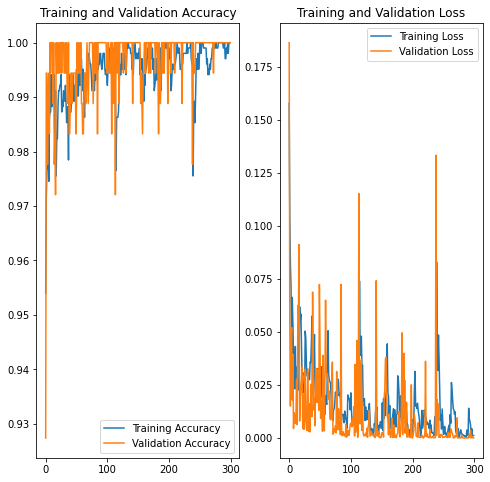

In [6]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

#epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# Save Model

In [7]:
#model.save_weights('./back_front_v000') # only saves the weights, not the structure
model.save(SAVEFILE)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: mtg_back_front_classifier_v004/assets
